# Tensorflow Transformer (Base) Implementation (shared emb 0x02)
----

Well, I tried to understand the transformers in full detail but without "using" them in practice, but in theory. In this notebook I will simply reimplement/recreate the Tensorflow example transformer (https://www.tensorflow.org/tutorials/text/transformer) and later try to train it on my data, rather than to understand it first and then implement the transformer by myself from scratch (There is no value in doing so and it makes things even harder). 

I was way too much into the idea, to not use other peoples code and develop it on my own, but what I forgot is, that this ting is already invented and was implemented multiple times. When I started my project there weren't that many implementation out there, which were easy enough to understand, they were rather optimized for speed and did lots of tricks to achieve that. That made understanding the code so much harder, that I sticked to the idea to have to implement a transformer as simple as possible. But now thankfully such simple transformers exists (even as a tutorial). So there is no need to stick to this idea any further.

I think it should be clear, that it is better to start with something that works (a fully implemented transformer) and then to experiment with it and then improve and modify it. As already stated, other transformer implementations were somehow too complicated and specialized, rather than simple. The Tensorflow transformer is simple enough to reimplement and to extend for own purposes.

So the original code is licensed under Apache 2.0 License.

`
Except as otherwise noted, the content of this page is licensed under the Creative Commons Attribution 4.0 License, and code samples are licensed under the Apache 2.0 License. For details, see the Google Developers Site Policies. Java is a registered trademark of Oracle and/or its affiliates.
`

This code may still be rewritten and/or refactored later if it works. This python notebook should be seen as my way to start a transformer for my future experiments.

Main of the code is not mine, but i made some modifications to it. For the original code please refer to the transformer tutorial website of tensorflow mentioned above.

So here we go...

In [1]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


## Preparing the input pipeline
----
This is a translation example (NMT) from the method body into the method name

In [2]:
import os
import json


In [52]:
# Length of a "sentence"
MAX_LENGTH = 200

# ??
BUFFER_SIZE = 40000

# Number of sentences processed in one batch
BATCH_SIZE = 128

In [53]:
# load the context dataset
context_dataset = tf.data.TextLineDataset( 
    os.path.join('D:\\Downloads\\Big-Code-excerpt','NextLineTranslationDataset.jsonl.from'))

# load the prediction dataset
nextline_dataset = tf.data.TextLineDataset(
    os.path.join('D:\\Downloads\\Big-Code-excerpt','NextLineTranslationDataset.jsonl.to'))

In [54]:
SYMBOL_START = 16273
SYMBOL_EOS = 16274
SYMBOL_PAD = 0
VOCAB_SIZE = 16275

In [55]:

# [16273] is the first element outside of the vocabulary, ans serves as a start element.
# [0] serves as a padding element
def my_json_decode(source, target):
    source_decoded = [SYMBOL_START] + json.loads(source.numpy()) + [SYMBOL_EOS] + [SYMBOL_PAD]
    target_decoded = [SYMBOL_START] + json.loads(target.numpy()) + [SYMBOL_EOS] + [SYMBOL_PAD]
    return source_decoded, target_decoded

def tf_context_nextline_json_decode(context, nextline):
    result_context, result_nextline = tf.py_function(my_json_decode, [context, nextline], [tf.int64, tf.int64])
    result_context.set_shape([None])
    result_nextline.set_shape([None])

    return result_context, result_nextline

def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

# combine both datasets in a parallel corpus
train_dataset_ = tf.data.Dataset.zip((context_dataset, nextline_dataset))
# transform from string to bpe encoded message
train_dataset__ = train_dataset_.map(tf_context_nextline_json_decode)

# filter dataset entries exceeding the capacity
train_dataset = train_dataset__.filter(filter_max_length)

# now do preprocessing and shuffle data around
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Prepare distribution strategy

We want to learn across multiple GPU's


In [7]:
# strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


## Positional Encoding
----
The positional encoding solves the problem that the transformer itself is not aware of the position of a word in a sentence, other than in RNNs or Convolutional networks. Therefore a positional encoding is added to the given model.

In [8]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


In [9]:
pos_encoding = positional_encoding(50,512)
print(pos_encoding.shape)

(1, 50, 512)


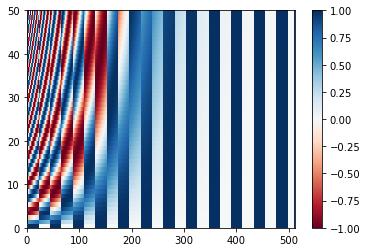

In [10]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlim((0,512))
plt.colorbar()
plt.show()

## Masking
----
The masking is a feature which is required for the decoder side of the transformer architecture. If we want to detect the next word/token, we must not provide the "solution", but instead we have to cut the solution of while training the decoder. This is done via a upper diagonal mask. (also called look ahead mask)

In [11]:
def create_padding_mask(seq):
    # this will create a mask from the input, whereever the input is Zero, it is treated as a padding.
    # and a one is written to the result, otherwise a Zero is written to the array (where true -> '1.0': else '0.0')
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # Mask has dimensions (batchsize, 1,1, seq_len)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [12]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


temp = create_look_ahead_mask(3)
temp

## Scaled dot product attention
----


In [13]:
#def scaled_dot_product_attention(query, key, value, mask):
#    matmul_qk = tf.matmul(query, key, transpose_b=True) 
#    
#    embedding_dimensions = tf.cast(key.get_shape()[-1], tf.float32)
#    scaled_attention_logits = matmul_qk / tf.math.sqrt(embedding_dimensions)
#    
#    if mask is not None:
#        scaled_attention_logits += (mask * -1e9)
#    
#    # ..., seq_len_q, seq_len_k
#    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
#    
#    # ..., seq_len_q, depth_v
#    output = tf.matmul(attention_weights, value)
#    
#    return output, attention_weights

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## Multi-head attention
----


In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

#temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
#y = tf.random.uniform((1,60,512))
#out, attn = temp_mha(y,k=y, q=y, mask=None)
#out.shape, attn.shape

## Point wise feed forward network
----


In [15]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

#sample_ffn = point_wise_feed_forward_network(512,2048)
#sample_ffn(tf.random.uniform((64,50,512))).shape


# Encoder / Decoder
----
Now the real fun part...

## Encoder Layer
----

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self,x,training,mask):
        # first sublayer
        attn_output,_ = self.mha(x,x,x,mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x+attn_output)
        
        # second sublayer
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2
    

sample_encoder_layer = EncoderLayer(512,8,2048)
sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64,50,512)), False, None)
sample_encoder_layer_output.shape

## Decoder Layer
----

In [17]:
class DecoderLayer( tf.keras.layers.Layer ):
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # first sublayer
        attn1, attn_weights_block1 = self.mha1(x,x,x,look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        # second sublayer
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        # third sublayer
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

sample_decoder_layer = DecoderLayer(512,8,2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(tf.random.uniform((64,50,512)), sample_encoder_layer_output, False, None, None)
sample_decoder_layer_output.shape

## Encoder
----

In [18]:
common_embedding = None

def get_common_embedding ( input_vocab_size, d_model ):
    global common_embedding
    
    if common_embedding is None:
        common_embedding =tf.keras.layers.Embedding(input_vocab_size, d_model)
    
    return common_embedding
    

In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        #self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.embedding = get_common_embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)
        x*= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x+= self.pos_encoding[:, :seq_len, :]
        
        x= self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
            
        return x

sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048, 
                         input_vocab_size=8500,
                         maximum_position_encoding=1000)

temp_input=tf.random.uniform((64,62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)
sample_encoder_output.shape

## Decoder
----


In [20]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = get_common_embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self,x,enc_output, training, look_ahead_mask, padding_mask):
        seq_length= tf.shape(x)[1]
        attention_weights = {}
        
        # batchsize, sequence_length, d_model
        x  =self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x +=self.pos_encoding[:, :seq_length, :]
        
        x= self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x,  block1, block2 = self.dec_layers[i](x,enc_output, training, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        return x, attention_weights
        


sample_decoder = Decoder(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    target_vocab_size = 8000, maximum_position_encoding=5000)
temp_input = tf.random.uniform((64,26), dtype=tf.int64,minval=0, maxval=200)

output, attn = sample_decoder(temp_input, enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

## Create the Transformer
----

In [21]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, 
             enc_padding_mask, look_ahead_mask, dec_padding_mask):
        # batch_size, inp_seq_length, d_model
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights
    

In [22]:
#sample_transformer = Transformer(
#    num_layers=2, d_model=512, num_heads=8, dff=2048, 
#    input_vocab_size=8500, 
#    target_vocab_size=8000, 
#    pe_input=10000, pe_target=6000)

#emp_input = tf.random.uniform((64,38), dtype=tf.int64, minval=0, maxval=200)
#emp_target = tf.random.uniform((64,36), dtype=tf.int64, minval=0, maxval=200)

#n_out, _ = sample_transformer(temp_input, temp_target, 
#                              training = False,
#                              enc_padding_mask=None,
#                              look_ahead_mask=None,
#                              dec_padding_mask=None)

#n_out.shape

#sample_transformer.summary()

## The hyperparameters
----
Man sollte vermutlich erst einmal mit 2 oder 3 layern arbeiten. um zu sehen, ob das ganze funktioniert. Vielleicht später mal mit 4 oder 6 Layern - Das große Problem ist Rechenzeit...

Einige der Parameter sind bereits fest. So zum beispiel, dass wir 512 dimensionale Vektoren verwenden. Diese sind bereits berechnet und sie waren aufwändig zu berechnen. Wir reden hier von mehreren Tagen mit meinem Setup.


In [23]:
num_layers = 4
d_model = 256
dff=1024
num_heads = 8

bpe_encoder_vocab_size = 16272
## +2 because of padding and masking
input_vocab_size = bpe_encoder_vocab_size + 3
target_vocab_size = bpe_encoder_vocab_size + 3


#input_vocab_size = tokenizer_pt.vocab_size + 2
#target_vocab_size = tokenizer_en.vocab_size + 2


dropout_rate = 0.09

## Optimizer - The Custom Learning rate
----


In [24]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model=d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5 )
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [25]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.995, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

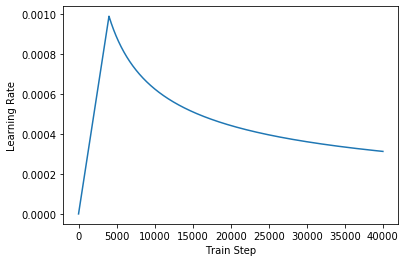

In [26]:
sample_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(sample_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and Metrics
----

In [27]:
#with strategy.scope():
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [28]:
#with strategy.scope():
def loss_function(real, pred):
    mask=tf.math.logical_not(tf.math.equal(real,0))

    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)

    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [29]:
#with strategy.scope():
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

## Training and Checkpointing
----


In [30]:
# with strategy.scope():
transformer = Transformer(num_layers, d_model, num_heads, dff,
                      input_vocab_size, target_vocab_size,
                     pe_input=input_vocab_size, pe_target=target_vocab_size,
                     rate=dropout_rate)


In [31]:
def create_masks(inp, tar):
    # encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    
    # wird im second attentionblock im decoder benutzt, um den input zu maskieren
    dec_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

In [32]:
checkpoint_path = "./checkpoints/train_ce_20201003"
ckpt = tf.train.Checkpoint( transformer = transformer, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')


Latest checkpoint restored!


In [33]:
EPOCHS = 6

In [34]:
train_step_signature = [
    tf.TensorSpec(shape=(None,None), dtype=tf.int64),
    tf.TensorSpec(shape=(None,None), dtype=tf.int64)
]

@tf.function(input_signature = train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)
    # Some zero gradients return null, we override them with zero
    gradients = [gradient if gradient is not None else tf.zeros_like(var) for var, gradient in zip(transformer.trainable_variables, gradients)]
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [49]:
def decision_loss(train_loss, train_acuracy):
    return train_loss / (1.000001-train_acuracy)

3.13535018364194

In [56]:
                                         


for epoch in range(128,130):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp,tar)

        if batch%100 ==0:
            print('Epoch{} Batch {} Loss {:.4f} Accuracy {:.4f}, Decision Loss {:.4f}'.format(
                epoch+1, batch, train_loss.result(), train_accuracy.result(), decision_loss(train_loss.result(),train_accuracy.result() ))
            )

    if (epoch+1)%2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}, Decision Loss {:.4f}'.format(epoch+1, train_loss.result(), train_accuracy.result(),decision_loss(train_loss.result(),train_accuracy.result() )))

    print('Time taken for one epoch: {} secs\n'.format(time.time()-start))

Epoch129 Batch 0 Loss 3.1426 Accuracy 0.1550, Decision Loss 3.7193
Epoch129 Batch 100 Loss 2.9919 Accuracy 0.1458, Decision Loss 3.5027
Epoch129 Batch 200 Loss 2.9645 Accuracy 0.1422, Decision Loss 3.4560


KeyboardInterrupt: 

## Save the current Model

In [36]:
model_save_path = '../../data/checkpoints/nextlineofcode_s_emb/v5/tf'

In [37]:
transformer.save_weights(model_save_path)

In [38]:
transformer.summary()


Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  7325440   
_________________________________________________________________
decoder (Decoder)            multiple                  8380160   
_________________________________________________________________
dense_64 (Dense)             multiple                  4182675   
Total params: 15,721,875
Trainable params: 15,721,875
Non-trainable params: 0
_________________________________________________________________


## Evaluation of the training using a validation dataset
----


In [ ]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
  
    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
  
    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
    
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
    
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()


In [ ]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                              if i<tokenizer_en.vocab_size])
    
    print('Input: {}'.format(sentence))
    print('Predicted Translation: {}'.format(predicted_sentence))
    
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)
        
#translate("este é um problema que temos que resolver.")
#print ("Real translation: this is a problem we have to solve .")


In [ ]:
#translate("este é o primeiro livro que eu fiz.", plot='decoder_layer6_block2')
#print ("Real translation: this is the first book i've ever done.")


## Predict first line.

In [ ]:
import sys
sys.path.insert(0,'../../src')

from com.github.c2nes.javalang import tokenizer as tokenizer

from de.mindscan.fluentgenesis.bpe.bpe_model import BPEModel
from de.mindscan.fluentgenesis.bpe.bpe_encoder_decoder import SimpleBPEEncoder

from de.mindscan.fluentgenesis.transformer import TfTransformerV1

In [ ]:
bpe_model = BPEModel("16K-full", "../../src/de/mindscan/fluentgenesis/bpe/")
bpe_model.load_hparams()

bpe_model_vocabulary = bpe_model.load_tokens()
bpe_model_bpe_data = bpe_model.load_bpe_pairs()

bpe_encoder = SimpleBPEEncoder(bpe_model_vocabulary, bpe_model_bpe_data)

In [ ]:
START_TOKEN = 16273
PAD_TOKEN = 0
MAX_OUTPUTLENGTH = 64

def tokenize_java_code(theSource: str):
    tokens = list(tokenizer.tokenize(theSource, ignore_errors=True))
    tokenvalues = [x.value for x in tokens]
    
    return tokenvalues

def plot_prediction_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
 
    attention = tf.squeeze(attention[layer], axis=0)
 
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
 
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')
 
        fontdict = {'fontsize': 10}
 
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)+1))
 
        ax.set_ylim(len(result)-1.5, -0.5)
 
        ax.set_xticklabels(
            ['<start>']+[bpe_encoder.decode([i])[0] for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)
 
        ax.set_yticklabels([bpe_encoder.decode([i])[0] for i in result 
                            if i < START_TOKEN], 
                           fontdict=fontdict)
 
        ax.set_xlabel('Head {}'.format(head+1))
 
    plt.tight_layout()
    plt.show()

#
# the following function shall sample the first line of a method, from a transformer
# greedy decoder...
#
def sample_transformer_nextline(transformer, class_name, method_name, method_signature):
    # we encode the class_name
    # we encode the method signature
    # we encode the line context
    input_tokens = [SYMBOL_START] + bpe_encoder.encode([class_name,'.',method_name]) + bpe_encoder.encode( tokenize_java_code( method_signature)) + [SYMBOL_EOS]
    encoderinput = tf.expand_dims(input_tokens,0)
    
    # this are the output tokens
    output_tokens = []
    # add start token to output_tokens
    output_tokens.append(START_TOKEN)
    output = tf.expand_dims(output_tokens,0)
    
    for _ in range(MAX_OUTPUTLENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoderinput,output)
        
        predictions, attention_weights = transformer(encoderinput,
                                                     output, 
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask
                                                     )
        predictions = predictions[:,-1, :]
        # greedy sampling
        # predicted_id = tf.argmax(predictions, axis=-1, output_type=tf.int32)
        predicted_id = tf.random.categorical(logits=predictions, num_samples=1)[0]
        
        if predicted_id in(PAD_TOKEN, SYMBOL_EOS):
            return tf.squeeze(output, axis=0), attention_weights, input_tokens
        
        output = tf.concat( [output, [predicted_id]], axis=-1 )
        
    return tf.squeeze(output, axis=0), attention_weights, input_tokens

In [ ]:
def predict_first_line(transformer, class_name, method_name, method_signature, plot=''):
    result, attention_weights, input_tokens = sample_transformer_nextline(transformer, class_name, method_name, method_signature)

    #result = [i for i in result.numpy() if ((i > 0) and (i<16273))]
    result = [i for i in result.numpy()]
    input_tokens = [i for i in input_tokens if ((i > 0) and (i<16273))]
    # input_tokens = [i for i in input_tokens]
    
    predicted_line = bpe_encoder.decode(result)
    decoded_input_tokens = bpe_encoder.decode(input_tokens)
    
    print ('Input Context: {}'.format(decoded_input_tokens))
    print ('Predicted output: {}'.format(predicted_line))
    
    if plot:
        # plot the attention weights
        plot_prediction_attention_weights(attention_weights, input_tokens, result, plot) 
    
    pass

In [ ]:
predict_first_line(transformer, 'Config', 'getInstance', 'Config getInstance() if(config != null) { ', plot='decoder_layer4_block2')

In [ ]:
# bpe_encoder.decode([701, 47, 1465, 701, 1465, 41, 42, 310, 41, 701, 47, 690, 412, 346, 42, 124])

transformer_restored = TfTransformerV1.Transformer(
    num_layers=4, d_model=256, num_heads=8, dff=1024,
    input_vocab_size=16274, target_vocab_size=16274,
    pe_input=512, pe_target=512,
    rate=0.0
    )



transformer_restored.load_weights(filepath='../../data/checkpoints/nextlineofcode_by_context/v3/tf')


predict_first_line(transformer_restored, 'Config', 'getInstance', 'Config getInstance() if (Config.instance == null) {')